This example is created by *Shuvashish Mondal* with help from *Shammah Lilonfe, Stephen Cini, Joe Jackson, Dr. Daniel Laky, and Dr. Alexander Dowling* using the data and the equation from *"Nonlinear Regression Analysis and Its Applications - 1988 - Bates"* p.33 Example. This example below implements `parmest`, and `scipy` for parameter estimation, `DOE`for full factorial design and covarianve matrix caluculation and compare the parameter estimation and covariance matrix esitmated from `DOE` and `Parmest` with `scipy` and `Monte Carlo`.

**Equation:**  
    $$f(x, \theta) = \frac{\theta_1x}{\theta_2 + x}$$  
where,  
$\qquad f(x, \theta)\rightarrow$ reaction velocity (response / output variable)  
$\qquad \theta_1, \theta_2 \rightarrow$ parameters  
$\qquad x\rightarrow$ substrate concentration (control / decision variable)  

**Data:**  
<table>
  <thead>
    <tr>
      <th>Substrate</th>
      <th colspan="2">Velocity</th>
    </tr>
    <tr>
      <th>Concentration</th>
      <th colspan="2">(counts/min<sup>2</sup>)</th>
    </tr>
    <tr>
      <th>(ppm)</th>
      <th>(a) Treated</th>
      <th>(b) Untreated</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0.02</td>
      <td style="vertical-align: top; text-align: center;">76 <br> 47</td>
      <td style="vertical-align: top; text-align: center;">67 <br> 51</td>
    </tr>
    <tr>
      <td>0.06</td>
      <td style="vertical-align: top; text-align: center;">97 <br> 107</td>
      <td style="vertical-align: top; text-align: center;">84 <br> 86</td>
    </tr>
    <tr>
      <td>0.11</td>
      <td style="vertical-align: top; text-align: center;">123 <br> 139</td>
      <td style="vertical-align: top; text-align: center;">98 <br> 115</td>
    </tr>
    <tr>
      <td>0.22</td>
      <td style="vertical-align: top; text-align: center;">159 <br> 152</td>
      <td style="vertical-align: top; text-align: center;">131 <br> 124</td>
    </tr>
    <tr>
      <td>0.56</td>
      <td style="vertical-align: top; text-align: center;">191 <br> 201</td>
      <td style="vertical-align: top; text-align: center;">144 <br> 158</td>
    </tr>
    <tr>
      <td>1.10</td>
      <td style="vertical-align: top; text-align: center;">207 <br> 200</td>
      <td style="vertical-align: top; text-align: center;">160</td>
    </tr>
  </tbody>
</table>

In the table we have two different velocity data: treated and untreated, for each observation of substrate data. We will take the average of the two data for each observation for each type of velocity, and then calculate our parameters with that averagae data.

# Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.contrib.parmest import parmest # import parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
import pandas as pd
from itertools import product

# Generate Data

In [2]:
theta_true = [212.71, 0.0645]  # True parameter values

In [3]:
# Generate Data
def michaelis_menten_model_data(x, theta=theta_true):
    np.random.seed(42)
    """
    Michaelis-Menten model function to generate data.
    Vmax, Km = theta
    x: substrate concentration. ppm
    -----------------------------------------
    Returns the reaction rate. counts/min^2
    """
    Vmax, Km = theta
    f = (Vmax * x) / (Km + x)+np.random.normal(0, 5)  # Adding some noise
    return f

In [4]:
subs_conc = np.array([0.02, 0.06])
rxn_rate = michaelis_menten_model_data(subs_conc)
rxn_rate

array([ 52.8291329 , 104.99441414])

In [5]:
# substrate_concentration = [0.02, 0.06, 0.11, 0.22, 0.56, 1.10]

# treated_velocity = [[76, 47], [97, 107], [123, 139], [159, 152], [191, 201], [207, 200]]

In [6]:
# Organizing the data in a ``list`` consisting of ``dict``s of ``one key : one value``
data_treated = [
    {"substrate_concentration" : sc, "avg_velocity": rr} for sc, rr in zip(subs_conc, rxn_rate)
]

In [7]:
data_treated

[{'substrate_concentration': np.float64(0.02),
  'avg_velocity': np.float64(52.82913289523368)},
 {'substrate_concentration': np.float64(0.06),
  'avg_velocity': np.float64(104.99441413855014)}]

# PARMEST & DOE

## Creating an experiment class for both DOE and ParmEst
We will use this class for both parmest (to estimate the parameters) and DOE (To calculate the FIM and factorial design)

In [8]:
class ReactionVelocity(Experiment):

    # Defining the constructor for our model
    def __init__(self, data, theta_initial=None, scale_params=True):
        """
        Arguments:
            data: data from our experiment. type: 'dict'
            theta_initial: initial guess of the parameter values, dtype: dict. pass the values as theta_initial = {1 : <theta_1 initial value>, 2 : <theta_2 initial value>}
                default:  {1: 100, 2: 0.05}
                
        """
        self.conc = data["substrate_concentration"]
        self.vel = data["avg_velocity"]
        self.model = None
        self.theta_initial = theta_initial
        if self.theta_initial is None:
            self.theta_initial = {1: 100, 2: 0.02}  # default initial guess of theta[1] & theta[2]
        else:
            self.theta_initial = theta_initial

        if scale_params:
            self.theta_1_scale = 200
            self.theta_2_scale = 0.050
        else:
            self.theta_1_scale = 1
            self.theta_2_scale = 1

    # Creating the get_labeled_model which is a must for ``DOE`` and ``ParmEst``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
            self.finalize_model()
        return self.model

    
    def create_model(self):
        """
        Here, we will create different variables, parameters, and constraints
        """
        m = self.model = pyo.ConcreteModel()

        # theta_1
        m.theta_1 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.theta_initial[1])
        m.theta_2 = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.theta_initial[2])

        # substrate concentration (x) as a param, since the data is given          
        m.x = pyo.Var(domain = pyo.NonNegativeReals, initialize = self.conc)
        m.reaction_velocity = pyo.Var(domain = pyo.NonNegativeReals)
       
        @m.Constraint()  # since the ``Constraint`` is not a set of anything, so there is no argument
        def vel_con(m):
            return m.reaction_velocity == m.theta_1 * self.theta_1_scale * m.x / (self.theta_2_scale*m.theta_2 + m.x)

        # ======================================
        # Objective function
        """
        For some reason the``obj_function = "SSE"``in parmest ``Estimator`` does not work for LR ratio.
        That's why I have created the ``Total_Cost_Obj`` to minimize the SSE. You can ignore this and use default "SSE". 
        Both ``FirstStageCost`` and ``SecondStageCost`` are required for the ``Objective``, otherwise it will show ``AttributeError``
        """
        
        # # Stage-specific cost computation
        # m.FirstStageCost = pyo.Expression(initialize = 0)
        # m.SecondStageCost = pyo.Expression(expr = (self.vel - m.reaction_velocity) ** 2)

        # m.Total_Cost_Obj = pyo.Objective(expr = (m.FirstStageCost + m.SecondStageCost), sense = pyo.minimize)
        # # ======================================

            
        # m.pprint()
        
        return m

    
    def finalize_model(self):
        """
        Finalizing the model. Here, we will set the experimental conditions (e.g, initial conditions),
        fixing the parameter values (if needed), update `t` values, and discretize the model (if model is dynamic). 
        It makes a solvable model.
        """        
        m=self.model

        # fixing the parameters
        m.theta_1.fix(self.theta_initial[1]) 
        m.theta_2.fix(self.theta_initial[2]) 

        # Add lower and upper bound to substrate concentration (control variable)
        m.x.setlb(0)
        m.x.setub(2)

        # fixing the substrate concentration (control variable)
        m.x.fix(self.conc)

        return m

    
    def label_model(self):
        """
        The model is updated with outputs, and unknown parameters. This makes the model labeled with full experiment.
        In `ParmEst` output (given data) is the most important. For `DOE` input is most important.
        """
        m = self.model

        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)  
        m.experiment_outputs.update([(m.reaction_velocity, self.vel)])  # Pass the data as a list of `tuple`
        # If we only use ``DOE``, we could use ``m.experiment_ouputs.update([(m.x, None)])``.
        # Output is not important for ``DOE``

        m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)    
        # m.experiment_inputs[m.x] = self.conc
        m.experiment_inputs.update([(m.x, self.conc)])
        # If we only use ``DOE``, we could use ``m.experiment_inputs.update([(m.x, None)])``

        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.theta_1, m.theta_2])
        # m.unknown_parameters[m.theta_1]= self.theta_initial[1]
        # m.unknown_parameters[m.theta_2]= self.theta_initial[2]

        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        # m.measurement_error[m.reaction_velocity] = 5
        m.measurement_error.update([(m.reaction_velocity, 5)]) 

        return m

# RUN 1
## Parmest Example
We will evaluate diffent parameters, visualize pairwise plots and show bootstrap table

### Treated velocity
Here, we will calculate objective value at optimum parameter value, paramater values, $\theta$, and covariance matrix for treated velocity.

In [9]:
exp_list = []  # list to hold each experiment
n_exp = len(data_treated)

# exp_list to separate each experiment
for i in range(n_exp):
    exp_list.append(ReactionVelocity(data_treated[i],))

# Creating an Estimator object
pest = parmest.Estimator(exp_list, obj_function="SSE", tee = True)

# Estimating d
obj, theta = pest.theta_est()

# ``parmest`` can mess up the order of the theta estimates and also the covariance. So we need to fix the order so that we can manipulate it properly.
t_order = ["theta_1", "theta_2"]
theta_perm = theta.loc[t_order]  # ``theta`` in the order we want

print("\ntheta values:")
print(theta_perm)

print("\nSSE value: ", obj)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

## DOE

In [10]:
theta_initial = {1: theta_perm["theta_1"], 2: theta_perm["theta_2"]}
data = data_treated

In [11]:
def run_reactor_doe(data, n_exp, theta_initial):
    """
    Argument:
    design_ranges: a `list`. [start, stop, number_of_points]. This argument is required for full factorial design.
    """
    FIM = []
    for i in range(n_exp):
        # Create a ReactorVelocity object for each experiment
        experiment = ReactionVelocity(
            data[i],
            theta_initial=theta_initial,
        )

        scale_nominal_param_value = False
        doe_obj = DesignOfExperiments(
            experiment, scale_nominal_param_value=scale_nominal_param_value, objective_option="trace", tee=True
        )
        # I haven't passed the other arguments, because the defaults values are used in the doe example.

        FIM.append(doe_obj.compute_FIM())

    # Let's sum up the FIM to get the total FIM of all the experiments and then use that FIM as a prior_FIM in `compute_FIM_full_factorial()`
    FIM_prior = np.array(FIM).sum(axis=0)
    return FIM_prior

In [12]:
def compute_fim_metric(FIM, FIM_prior=None):
    """
    Compute D-, A-, E-, and ME-optimality metrics from the Fisher Information Matrix (FIM).
    Arguments:
        FIM: Fisher Information Matrix (numpy array)
    Returns:
        D_opt: D-optimality metric (log determinant of FIM)
        A_opt: A-optimality metric (log trace of inverse of FIM)
        E_opt: E-optimality metric (log minimum eigenvalue of FIM)
        ME_opt: ME-optimality metric (log condition number of FIM)"""
    FIM = FIM if FIM_prior is None else FIM + FIM_prior
    D_opt = np.log10(np.linalg.det(FIM))
    A_opt = np.log10(np.trace(np.linalg.inv(FIM)))
    pseudo_A_opt = np.log10(np.trace(FIM))
    E_opt = np.log10(np.min(np.linalg.eigvals(FIM)))
    ME_opt = np.log10(np.linalg.cond(FIM))
    return D_opt, A_opt, pseudo_A_opt, E_opt, ME_opt

In [13]:
FIM = run_reactor_doe(data, n_exp, theta_initial)
cov_doe = np.linalg.inv(FIM)
np.set_printoptions(precision=2, suppress=False)
print(f"FIM for {n_exp} experiments\n", FIM)
np.set_printoptions(suppress=False, formatter={'float': '{:.2e}'.format})
print("\nCov of the Experiment using ``DOE``\n", cov_doe)

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

## Eigendecomposition

In [14]:
# Eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(FIM)
print("\nEigenvalues of the FIM:\n", eigenvalues)
print("\nEigenvectors of the FIM:\n", eigenvectors)


Eigenvalues of the FIM:
 [6.34e+02 3.33e+00]

Eigenvectors of the FIM:
 [[9.00e-01 4.37e-01]
 [-4.37e-01 9.00e-01]]


In [15]:
factorial_design = np.linspace(0.01, 2, 30)
FIM_metric = {
    "substrate concentration": [],
    "D_opt": [],
    "A_opt": [],
    "pseudo_A_opt": [],
    "E_opt": [],
    "ME_opt": [],
}
for subs_c in factorial_design:
    exp_sens = ReactionVelocity(
        data={"substrate_concentration": subs_c, "avg_velocity": None},
        theta_initial=theta_initial,
    )
    doe_sens = DesignOfExperiments(exp_sens, scale_nominal_param_value=False, tee=True)
    FIM_ff = doe_sens.compute_FIM()
    FIM_metric["substrate concentration"].append(subs_c)

    # compute FIM metric
    D_opt, A_opt, pseudo_A_opt, E_opt, ME_opt = compute_fim_metric(FIM=FIM_ff, FIM_prior=FIM)
    FIM_metric["D_opt"].append(D_opt)
    FIM_metric["A_opt"].append(A_opt)
    FIM_metric["pseudo_A_opt"].append(pseudo_A_opt)
    FIM_metric["ME_opt"].append(ME_opt)

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [21]:
FIM_metric["pseudo_A_opt"]

[np.float64(2.8396813878520013),
 np.float64(3.0930041203632728),
 np.float64(3.1787270849982465),
 np.float64(3.2210044514127443),
 np.float64(3.2463853174247173),
 np.float64(3.2633629626595884),
 np.float64(3.275533666661576),
 np.float64(3.2846915599517015),
 np.float64(3.291834582200836),
 np.float64(3.297562928623206),
 np.float64(3.3022595792127976),
 np.float64(3.3061805434167577),
 np.float64(3.30950351061628),
 np.float64(3.3123557008320046),
 np.float64(3.3148306097771685),
 np.float64(3.3169984968901893),
 np.float64(3.3189131859897145),
 np.float64(3.3206166082101367),
 np.float64(3.3221419162830124),
 np.float64(3.3235156684633367),
 np.float64(3.3247593911131132),
 np.float64(3.325890716919657),
 np.float64(3.326924227429892),
 np.float64(3.327872085821629),
 np.float64(3.328744518430056),
 np.float64(3.3295501855998797),
 np.float64(3.3302964704514553),
 np.float64(3.3309897060095333),
 np.float64(3.3316353555185496),
 np.float64(3.3322381568312744)]

In [16]:
FIM_metric

{'substrate concentration': [np.float64(0.01),
  np.float64(0.07862068965517241),
  np.float64(0.14724137931034484),
  np.float64(0.21586206896551724),
  np.float64(0.28448275862068967),
  np.float64(0.3531034482758621),
  np.float64(0.42172413793103447),
  np.float64(0.4903448275862069),
  np.float64(0.5589655172413793),
  np.float64(0.6275862068965518),
  np.float64(0.6962068965517242),
  np.float64(0.7648275862068966),
  np.float64(0.8334482758620689),
  np.float64(0.9020689655172414),
  np.float64(0.9706896551724138),
  np.float64(1.0393103448275862),
  np.float64(1.1079310344827586),
  np.float64(1.176551724137931),
  np.float64(1.2451724137931035),
  np.float64(1.313793103448276),
  np.float64(1.3824137931034484),
  np.float64(1.4510344827586208),
  np.float64(1.5196551724137932),
  np.float64(1.5882758620689656),
  np.float64(1.6568965517241379),
  np.float64(1.7255172413793103),
  np.float64(1.7941379310344827),
  np.float64(1.8627586206896551),
  np.float64(1.9313793103448276)

## Plotting the factorial results

Star value for metric D_opt: (np.float64(2.0), np.float64(5.232167155444942))
Star value for metric A_opt: (np.float64(2.0), np.float64(-1.8999289986136672))
Star value for metric pseudo_A_opt: (np.float64(2.0), np.float64(3.3322381568312744))


Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

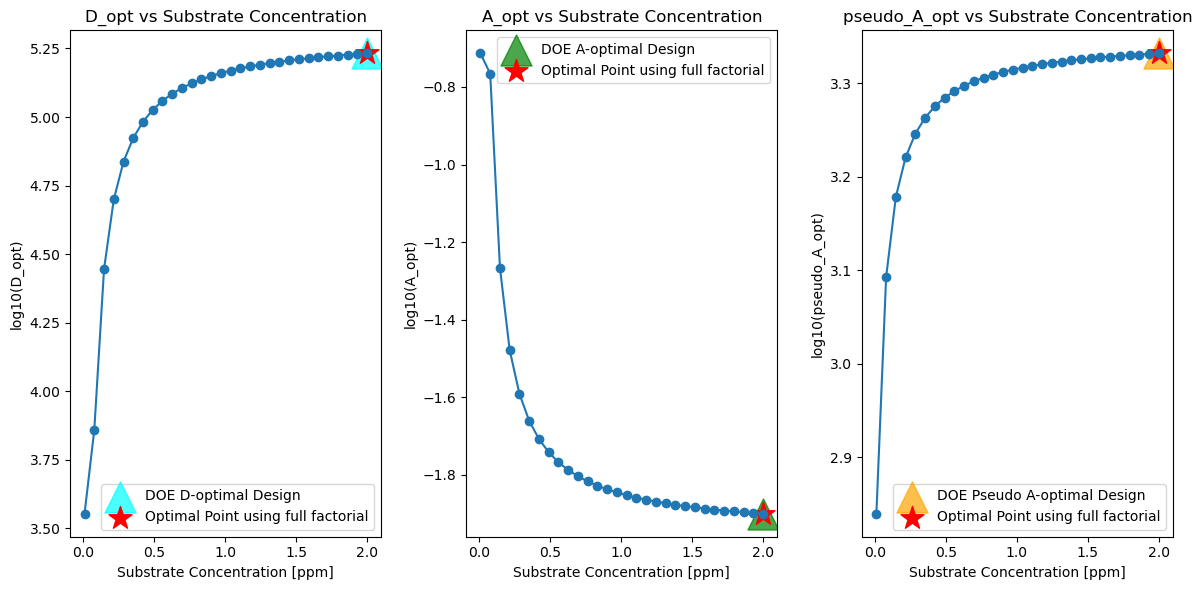

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
metrics_name = ["D_opt", "A_opt", "pseudo_A_opt"]
subs_conc_array = np.array(FIM_metric["substrate concentration"])
star_values = [
    (subs_conc_array[np.argmax(FIM_metric["D_opt"])], np.max(FIM_metric["D_opt"])),
    (subs_conc_array[np.argmin(FIM_metric["A_opt"])], np.min(FIM_metric["A_opt"])),
    (subs_conc_array[np.argmax(FIM_metric["pseudo_A_opt"])], np.max(FIM_metric["pseudo_A_opt"])),
    # (subs_conc_array[np.argmax(FIM_metric["E_opt"])], np.max(FIM_metric["E_opt"])),
    # (subs_conc_array[np.argmin(FIM_metric["ME_opt"])], np.min(FIM_metric["ME_opt"])),
]
for i in range(len(metrics_name)):
    print(f"Star value for metric {metrics_name[i]}: {star_values[i]}")


# Create a ReactorVelocity object for each experiment
experiment = ReactionVelocity(data[0], theta_initial=theta_initial)
# model = experiment.get_labeled_model()
# solver = pyo.SolverFactory('ipopt')
# solver.solve(model, tee=True)
scale_nominal_param_value = False
# experiment.get_labeled_model().x.set_value(1e-5)
doe_obj_a = DesignOfExperiments(
    experiment,
    step=0.01,
    scale_nominal_param_value=scale_nominal_param_value,
    objective_option="trace",
    prior_FIM=FIM,
    tee=True,
    improve_cholesky_roundoff_error=True,
)
doe_obj_a.run_doe()
A_optimal_conc = doe_obj_a.results['Experiment Design']

A_optimal_value = doe_obj_a.results['log10 A-opt']

doe_obj_pseudo_a = DesignOfExperiments(
    experiment,
    step=0.01,
    scale_nominal_param_value=scale_nominal_param_value,
    objective_option="pseudo_trace",
    prior_FIM=FIM,
    tee=True,
)

doe_obj_pseudo_a.run_doe()
pseudo_A_optimal_conc = doe_obj_pseudo_a.results['Experiment Design']

pseudo_A_optimal_value = doe_obj_pseudo_a.results['log10 pseudo A-opt']
print("\nPseudo A-optimal design substrate concentration:", pseudo_A_optimal_conc)
print("Pseudo A-optimal design value:", pseudo_A_optimal_value)

doe_obj_d = DesignOfExperiments(
    experiment,
    step=0.01,
    scale_nominal_param_value=scale_nominal_param_value,
    objective_option="determinant",
    prior_FIM=FIM,
    tee=True,

)
doe_obj_d.run_doe()
D_optimal_conc = doe_obj_d.results['Experiment Design']

D_optimal_value = doe_obj_d.results['log10 D-opt']
print("\nA-optimal design substrate concentration:", A_optimal_conc)
print("A-optimal design value:", A_optimal_value)
print("\nD-optimal design substrate concentration:", D_optimal_conc)
print("D-optimal design value:", D_optimal_value)

for i, metric in enumerate(metrics_name):
    ax = axes[i]
    ax.plot(subs_conc_array, FIM_metric[metric], marker='o')
    if metric == "A_opt":
        ax.scatter(
            x=A_optimal_conc,
            y=A_optimal_value,
            color='green',
            marker='^',
            s=500,
            alpha=0.7,
            label='DOE A-optimal Design',
        )
    elif metric == "pseudo_A_opt":
        ax.scatter(
            x=pseudo_A_optimal_conc,
            y=pseudo_A_optimal_value,
            color='orange',
            marker='^',
            s=500,
            alpha=0.7,
            label='DOE Pseudo A-optimal Design',
        )
    elif metric == "D_opt":
        ax.scatter(
            x=D_optimal_conc,
            y=D_optimal_value,
            color='cyan',
            marker='^',
            s=500,
            alpha=0.7,
            label='DOE D-optimal Design',
        )
    ax.scatter(
        star_values[i][0],
        star_values[i][1],
        color='red',
        marker='*',
        s=300,
        label='Optimal Point using full factorial',
    )

    ax.set_title(f"{metric} vs Substrate Concentration")
    ax.set_xlabel("Substrate Concentration [ppm]")
    ax.set_ylabel(f"log10({metric})")
    ax.legend()
plt.tight_layout()

In [18]:
doe_obj_pseudo_a = DesignOfExperiments(
    experiment,
    step=0.01,
    scale_nominal_param_value=scale_nominal_param_value,
    objective_option="pseudo_trace",
    prior_FIM=FIM,
    tee=True,
)

doe_obj_pseudo_a.run_doe()
pseudo_A_optimal_conc = doe_obj_pseudo_a.results['Experiment Design']

pseudo_A_optimal_value = doe_obj_pseudo_a.results['log10 pseudo A-opt']

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [19]:
print("\nPseudo A-optimal design substrate concentration:", pseudo_A_optimal_conc)
print("Pseudo A-optimal design value:", pseudo_A_optimal_value)


Pseudo A-optimal design substrate concentration: [1.999998839788492]
Pseudo A-optimal design value: 3.332238147008571


In [20]:
star_values

[(np.float64(2.0), np.float64(5.232167155444942)),
 (np.float64(2.0), np.float64(-1.8999289986136672)),
 (np.float64(2.0), np.float64(3.3322381568312744))]